In [1]:
# en este apartado se importan las librerias que se estaran utilizando al rededor del codigo 

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
import PIL
from PIL import Image
#
from jupyterthemes import jtplot
jtplot.style()

### GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Dataset and Dataloader

In [3]:
#Ruta donde se encuentran todos los datos 

PATH = 'C:/Users/dilan/Desktop/trabajos pendientes/PASANTIA/CODIGOS/Redes neuronales convolucionales' # ruta general
TRAIN_PATH = 'C:/Users/dilan/Desktop/trabajos pendientes/PASANTIA/CODIGOS/Redes neuronales convolucionales/train/train' # ruta para los datos de entrenamiento 
TRAIN_MASK_PATH = 'C:/Users/dilan/Desktop/trabajos pendientes/PASANTIA/CODIGOS/Redes neuronales convolucionales/train_masks/train_masks' # ruta para las mascaras 
TEST_PATH = 'C:/Users/dilan/Desktop/trabajos pendientes/PASANTIA/CODIGOS/Redes neuronales convolucionales/test/test' # ruta para las imagenes de prueba 

#### Dataset

In [4]:
# creando Dataset
# el dataset guarda las muestras y las etiquetas correspondientes 

# creaccion de objeto dataset que hereda de la clase Dataset de pytorch
class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        Rutas:
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        '''
        creacion de listas ordenadas con todos los elementos del folder que se ha seleccionado 
        '''
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    # retornar el numero de elementos de las listas  
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'el numero de imagenes es diferente al numero de mascaras'
        return len(self.images)

    # Funcion para regresar un elemento del dataset en la posicion del index
    # Ademas es aqui donde se aplican las transformaciones que se requieren en el dataset
    def __getitem__(self, idx):
        ''' concatenar la ruta con el nombre de la imagen en la posicion idx, obteniendo la ruta completa de la imagen '''
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()

        ''' validar y aplicar las transformaciones en caso de haberlas sino solamente convertir a tensor '''
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        ''' validar si se estan pasando mascaras '''
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)

            ''' en caso de transformacion a mascara aplicarla sino convertirla a tensor '''
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
                
            ''' normalizar '''
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img
        
        return img, mask             

#### transformations

In [5]:
# transformaciones para llevar a las imagenes a un tamaño mas manejable para los recursos computacionales y conversion a tensores de pytorch
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

#### Dataloaders

In [6]:
# El dataloader coloca un objeto iterable al rededor del dataset para acceder a él de forma sencilla  

''' Crear dataset completo '''
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASK_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [7]:
BATCH_SIZE = 32 # total de imagenes para el batch size
TRAIN_SIZE = int(len(full_dataset)*0.8) #total de datos de entrenamiento 
VAL_SIZE = len(full_dataset) - TRAIN_SIZE #total datos de validacion

In [8]:
#imprimir los datos
print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [9]:
# para obtener el dataset de entramiento y de validacion se usa la funcion random_split
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [10]:
#imprimir los datos de entrenamiento y validacion 
print(len(train_dataset), len(val_dataset))

4070 1018


In [11]:
#creacion de datalouder para entrenamiento y validacion
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# Generacion de mini batches de 32 datos para las imagenes y mascaras
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


In [13]:
#enumerar los mini batches para el entrenamiento e imprimmir solo los 10 primeros
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


#### Let us see the data

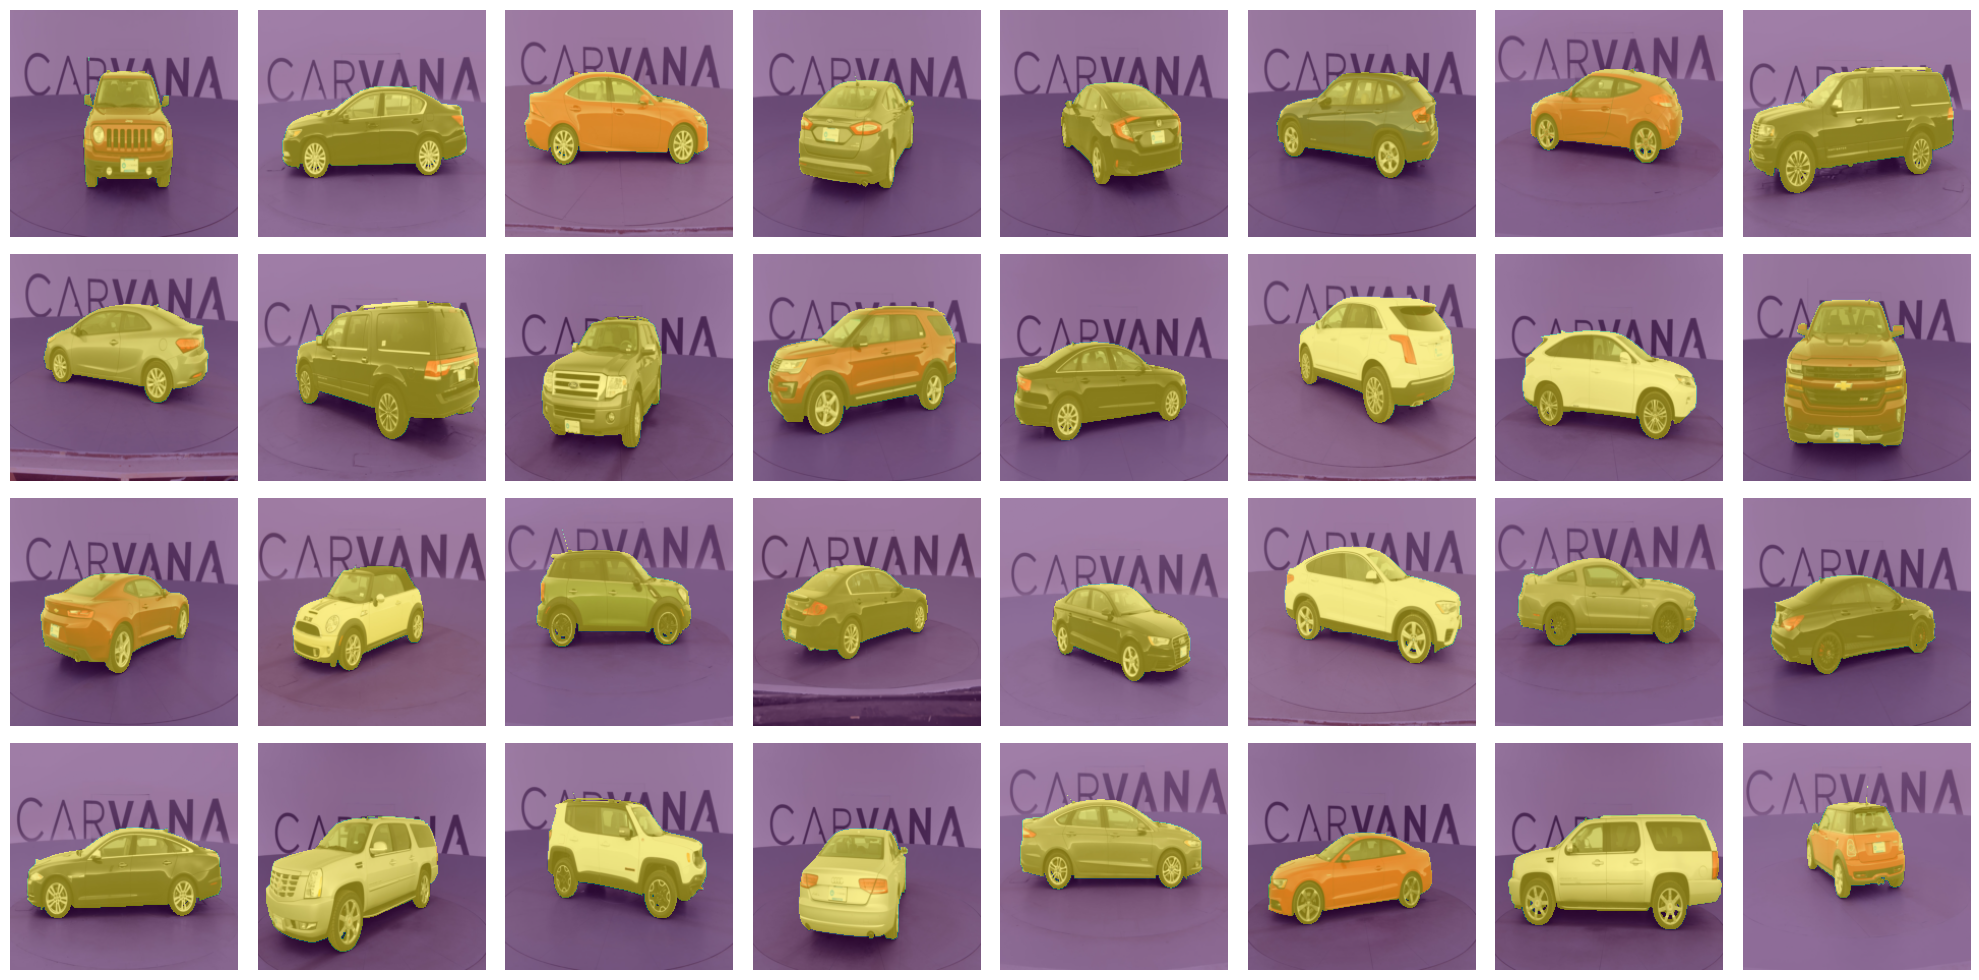

In [14]:
#Mostrar todos los elementos de un mini batch (imagen y mascara)

imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        
        ''' para graficar se necesita ancho, alto y canal y el tensor esta ordenado en canal, alto y ancho por lo que se necesita la funcion permute '''
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

### Accuracy

In [15]:

def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [16]:
len(train_loader)

128

#### Search for learning rate

In [17]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Train loop

In [18]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
                    # Save data
                    #train_acc_history.append(train_acc)
                    #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history ... etc    

### U-NET model

In [19]:
# Bloque para mantener parametros constantes y simplificar el codigo llamando solo a la funcion conv_3_k y no colocar los parametros manualmente
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [20]:
# Se crean las clases tomando como referencia el papper U-Net: Convolutional Networks for Biomedical Image Segmentation
# disponible en https://arxiv.org/abs/1505.04597   https://doi.org/10.48550/arXiv.1505.04597
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part - max pool 2x2 and Double convolution (se implementan las dos funciones en esta clase para simplificar el codigo)
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'), #duplicar y seleccionar el tipo de interpolacion 
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1) #convolucion de 1x1 
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume 
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)

        ''' concatenar x2 con x1 con dimension 1, correspondiente a los canales'''
        x = torch.cat([x2, x1],dim=1) 
        return self.decoder(x)
    
# creacion del modelo u-net    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()                                      #salidas
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1) 
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)
        

In [21]:
# Funcion de prueba para probar que las dimensiones del modelo son las esperadas 
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [22]:
preds = test()

In [23]:
print(preds.shape)

torch.Size([32, 2, 224, 224])


### Train model

In [25]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.7897, lr: 0.0000, acc: 0.2047
cost:0.7970, lr: 0.0000, acc: 0.1958
cost:0.8116, lr: 0.0000, acc: 0.1786
cost:0.7952, lr: 0.0000, acc: 0.1965
cost:0.8002, lr: 0.0000, acc: 0.1939
cost:0.7982, lr: 0.0000, acc: 0.1957
cost:0.8021, lr: 0.0000, acc: 0.1890
cost:0.8057, lr: 0.0000, acc: 0.1875
cost:0.7962, lr: 0.0000, acc: 0.1921
cost:0.7974, lr: 0.0000, acc: 0.1948
cost:0.7918, lr: 0.0000, acc: 0.2021
cost:0.7971, lr: 0.0000, acc: 0.2004
cost:0.7898, lr: 0.0000, acc: 0.2015
cost:0.7893, lr: 0.0000, acc: 0.2016
cost:0.7939, lr: 0.0000, acc: 0.2002
cost:0.7967, lr: 0.0000, acc: 0.1972
cost:0.7974, lr: 0.0000, acc: 0.1971
cost:0.7993, lr: 0.0000, acc: 0.1924
cost:0.8061, lr: 0.0000, acc: 0.1893
cost:0.7896, lr: 0.0000, acc: 0.2021
cost:0.7967, lr: 0.0000, acc: 0.1936
cost:0.7873, lr: 0.0000, acc: 0.2069
cost:0.7935, lr: 0.0000, acc: 0.1979
cost:0.8097, lr: 0.0000, acc: 0.1838
cost:0.7966, lr: 0.0000, acc: 0.1914
cost:0.7877, lr: 0.0000, acc: 0.2059
cost:0.7921, lr: 0.0000, acc: 0.1992
c

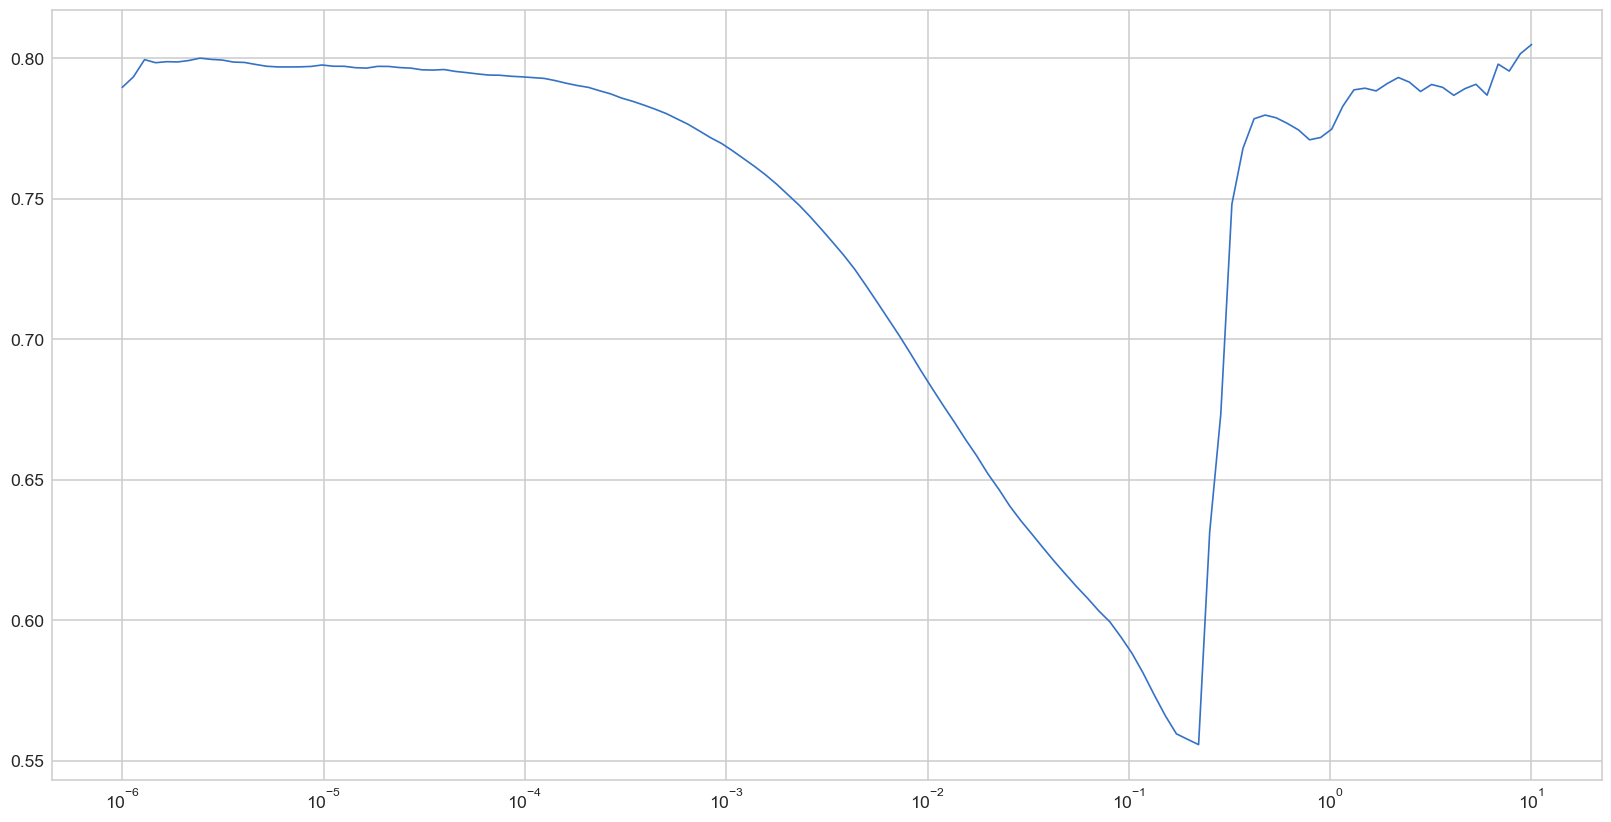

In [26]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [27]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [28]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.4956, val cost: 0.2845,train acc: 0.7318, val acc: 0.8823,dice: 0.6340168118476868, iou: 0.46414685249328613
epoch: 0, mb: 50, train cost: 0.3456, val cost: 0.1037,train acc: 0.8219, val acc: 0.9666,dice: 0.9213207960128784, iou: 0.8541192412376404
epoch: 0, mb: 75, train cost: 0.2540, val cost: 0.0530,train acc: 0.8725, val acc: 0.9796,dice: 0.9515645503997803, iou: 0.907604455947876
epoch: 0, mb: 100, train cost: 0.2022, val cost: 0.0411,train acc: 0.8999, val acc: 0.9839,dice: 0.9616383910179138, iou: 0.9261112809181213
epoch: 0, mb: 125, train cost: 0.1693, val cost: 0.0331,train acc: 0.9170, val acc: 0.9871,dice: 0.9691489934921265, iou: 0.9401447176933289
epoch: 1, mb: 25, train cost: 0.0299, val cost: 0.0299,train acc: 0.9882, val acc: 0.9879,dice: 0.9711839556694031, iou: 0.9439821243286133
epoch: 1, mb: 50, train cost: 0.0299, val cost: 0.0357,train acc: 0.9882, val acc: 0.9850,dice: 0.965044379234314, iou: 0.932449996471405
epoch: 1, mb: 75, tr

### Plot some images

torch.Size([32, 224, 224])


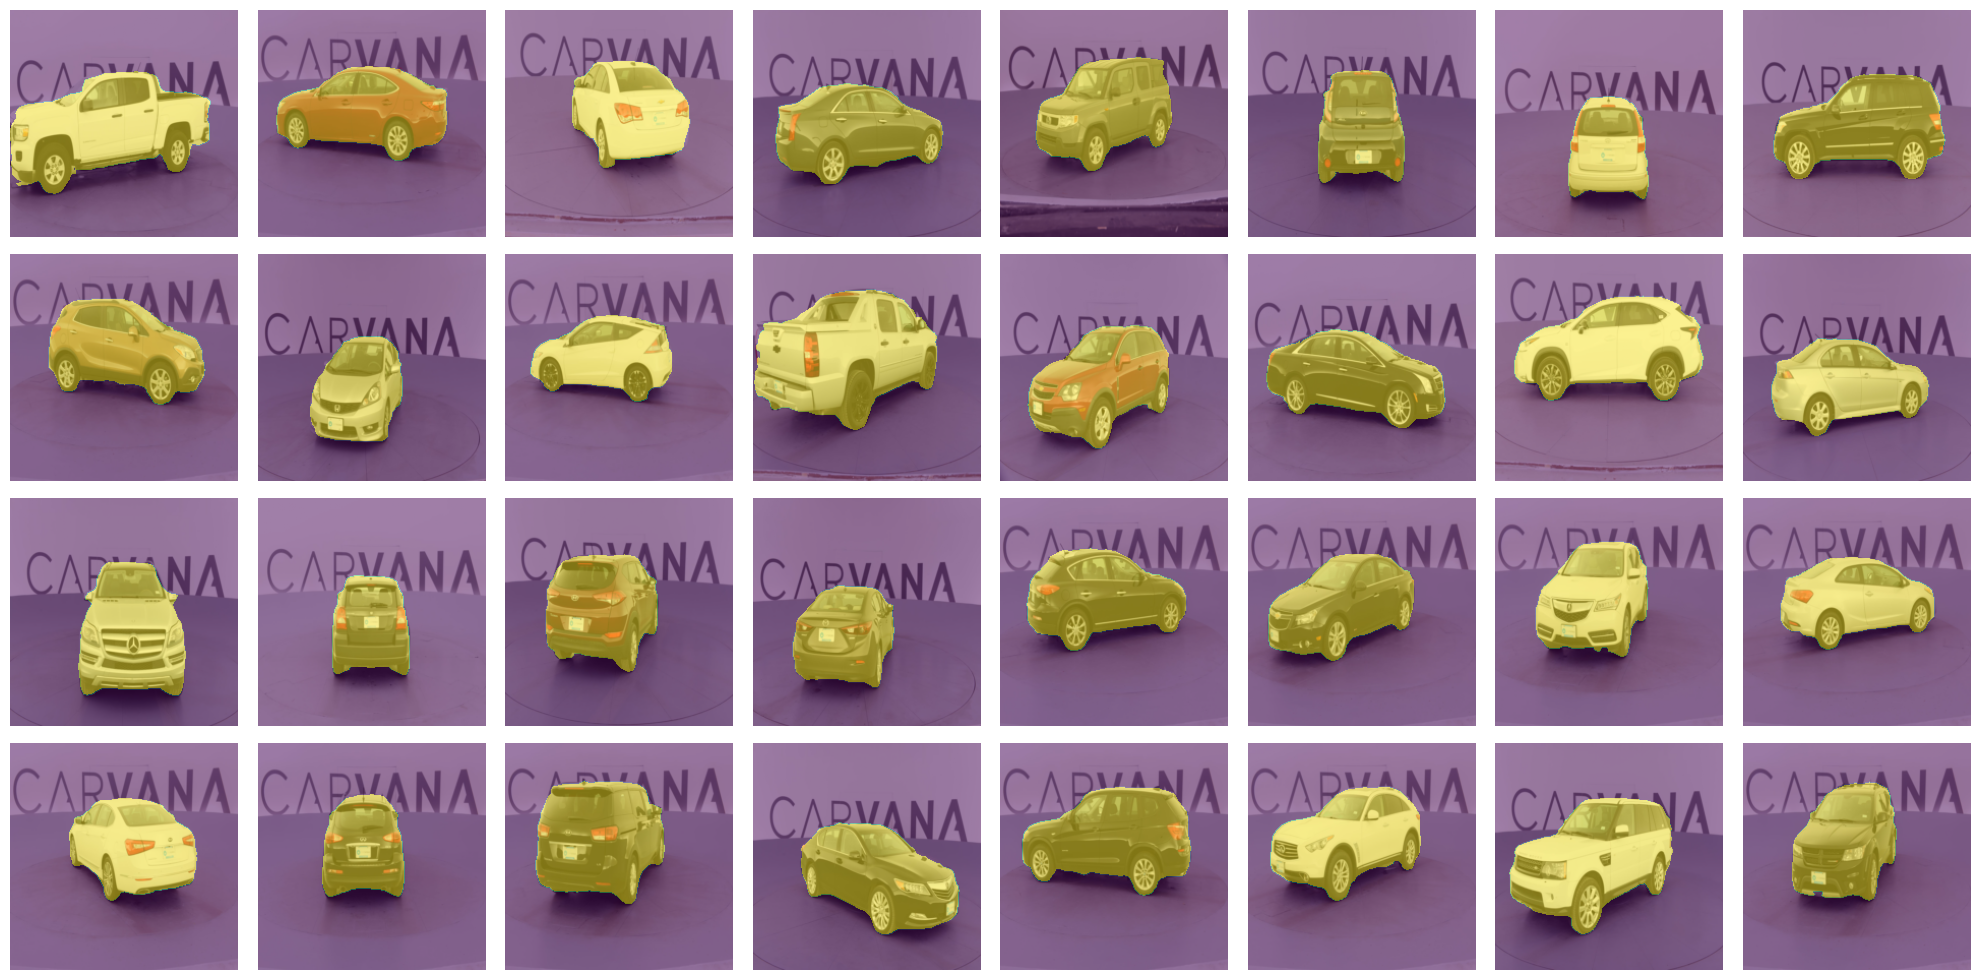

In [29]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [30]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 224, 224])


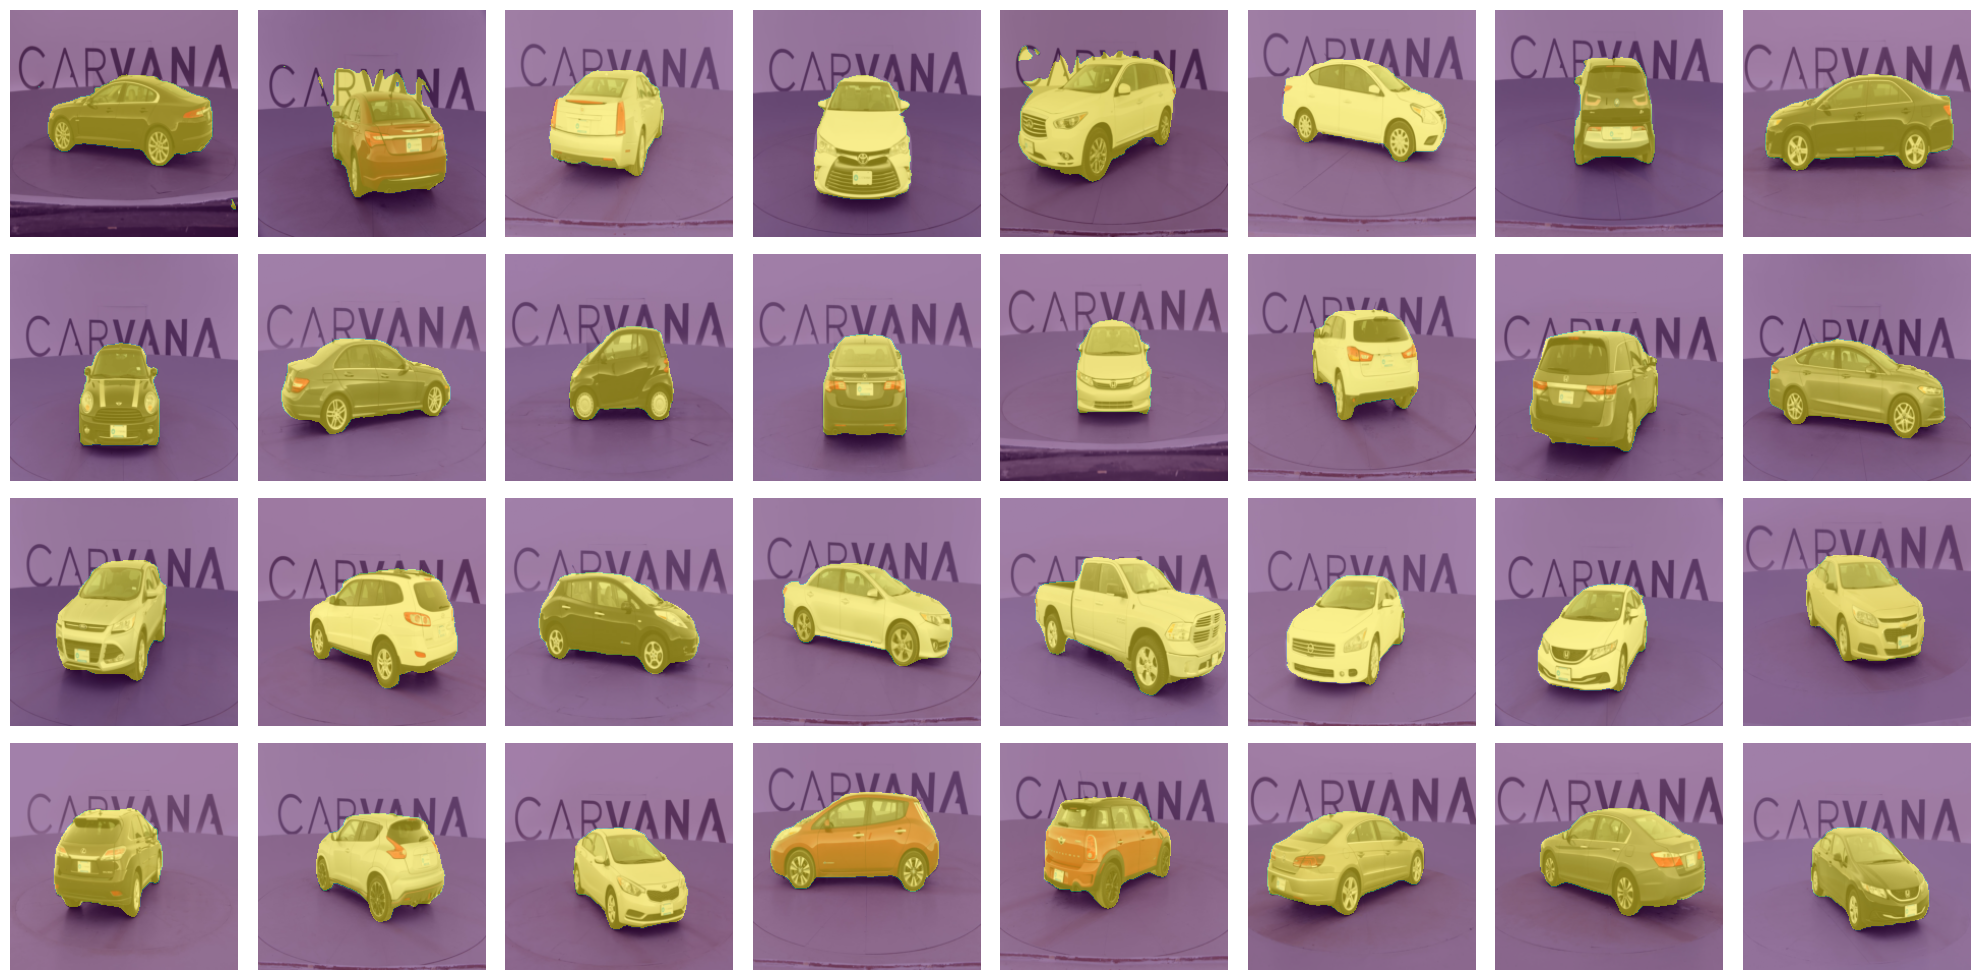

In [31]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [32]:
# Guardar modelo

model_path = './modelMNIST.pth'
torch.save(model.state_dict(), model_path)

model.state_dict

<bound method Module.state_dict of UNET(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): C

In [ ]:
#cargar modelo 
